# POP Atlantic BSF for 0.1-degree
**Input Data:** Monthly POP output timeseries files  
**Output Data:** Monthly mean BSF timeseries  
**Description:** Computes (approximate) Atlantic BSF offline from POP history files using simple zonal integral.  
**Date:** April 2023  
**Creator:** Steve Yeager  
**Updated:** Teagan King, April 2023 (modified to create full BSF output and to include Sunway product workflow)  
**Note:** It is recommended to run this notebook with ~30GB of memory

In [1]:
%load_ext autoreload
%autoreload 2
import cftime
import copy
import dask
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np  
import os
import pop_tools
import time
import xarray as xr 
from MOCutils import popmoc

In [2]:
from dask.distributed import wait
dask.__version__

'2022.7.0'

In [3]:
pop_tools.__version__

'2023.3.0'

In [4]:
# Close out Dask Cluster and release workers:
# client.shutdown()

In [5]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GiB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB', 
        account='P93300313',
        local_directory='/glade/scratch/tking',
        log_directory='/glade/scratch/tking',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        "distributed.scheduler.worker-saturation": "1.0",
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(70)

In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.24:35822,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
def time_set_midmonth(ds, time_name, deep=False):
    """
    Return copy of ds with values of ds[time_name] replaced with mid-month
    values (day=15) rather than end-month values.
    """
    year = ds[time_name].dt.year
    month = ds[time_name].dt.month
    year = xr.where(month==1,year-1,year)
    month = xr.where(month==1,12,month-1)
    nmonths = len(month)
    newtime = [cftime.DatetimeNoLeap(year[i], month[i], 15) for i in range(nmonths)]
    ds[time_name] = newtime
    return ds

In [8]:
fgrd = '/glade/work/fredc/cesm/grid/POP/grid.3600x2400x62.nc'
ds_grid = xr.open_dataset(fgrd)

# Compute BSF for RCP Products

### Get the required variables

In [9]:
fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP60/HR/b.e13.BRCP60C5.ne120_t12.cesm-ihesp-hires1.0.44.003/ocn/proc/tseries/month_1/'
# fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.30.002/ocn/proc/tseries/month_1/'
# fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.31.003/ocn/proc/tseries/month_1/'
# fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP45/HR/b.e13.BRCP45C5.ne120_t12.cesm-ihesp-hires1.0.42.003/ocn/proc/tseries/month_1/'
# fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP26/HR/b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003/ocn/proc/tseries/month_1/'

fin = fdir + 'b.e13.BRCP60C5.ne120_t12.cesm-ihesp-hires1.0.44.003.pop.h.VVEL.200601-210012.nc'
# fin = fdir + 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.30.002.pop.h.VVEL.200601-210012.nc'
# fin = fdir + 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.31.003.pop.h.VVEL.200601-210012.nc'
# fin = fdir + 'b.e13.BRCP45C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.VVEL.200601-210012.nc'
# fin = fdir + 'b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.VVEL.200601-210012.nc'

dsV = xr.open_dataset(fin, chunks={'time':1,'nlat':150})
dsV = time_set_midmonth(dsV,'time')

In [21]:
dsV.VVEL

<xarray.DataArray 'VVEL' (time: 1140, z_t: 62, nlat: 2400, nlon: 3600)>
dask.array<open_dataset-e5a82a7e6b29f47a13a6d36683812443VVEL, shape=(1140, 62, 2400, 3600), dtype=float32, chunksize=(1, 62, 150, 3600), chunktype=numpy.ndarray>
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(150, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(150, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(150, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(150, 3600), meta=np.ndarray>
  * time     (time) object 2006-01-15 00:00:00 ... 2100-12-15 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Velocity in grid-y direction
    units:         centimeter/s
    grid_loc:      3221
    cell_methods:  time: mean

In [11]:
vvel = dsV['VVEL']
vvel = vvel.where(vvel<1.e30,0)/100.

### Region Mask & Grid Fields

In [12]:
## Define the MOC region mask:
rmask = ds_grid.REGION_MASK.drop(['ULONG','ULAT'])
rmaskatl = (rmask==6) | (rmask==8) | (rmask==9)

In [13]:
%%time
dz = ds_grid['dz'].persist()/100.
kmt = ds_grid['KMT'].fillna(0).persist() 
dxu = ds_grid['DXU'].persist()/100.
# the next step takes about 23 seconds when run in a notebook with 30GB allocated memory
# and about 12 minutes with the default 4GB allocated memory
dzt,dzu = popmoc.tx0p1v3_dztdzu(dz,kmt)

CPU times: user 8.37 s, sys: 5.66 s, total: 14 s
Wall time: 17.9 s


In [14]:
tlon = ds_grid.TLONG.drop(['ULONG','ULAT'])
tlat = ds_grid.TLAT.drop(['ULONG','ULAT'])
ulon = ds_grid.ULONG.drop(['TLONG','TLAT'])
ulat = ds_grid.ULAT.drop(['TLONG','TLAT'])

### Compute BSF

In [15]:
%%time
sv = (vvel*dzt*dxu).sum('z_t')
sv.attrs['units']='m^3/s'
sv_atl = sv.where(rmaskatl).drop(['TLONG','TLAT'])
bsf = sv_atl.cumsum('nlon')/1.e6
bsf = xr.where(rmaskatl,bsf,0)
bsf = bsf.assign_coords({'ULAT':ulat,'ULONG':ulon})
bsf = bsf.where(kmt!=0).drop(['TLONG','TLAT'])
bsf = bsf.assign_attrs({'units':'Sv','long_name':'Barotropic Streamfunction'}).rename('BSF')
bsf = bsf.transpose('time','nlat','nlon')

CPU times: user 6.12 s, sys: 1.29 s, total: 7.41 s
Wall time: 1min 32s


In [16]:
%%time
bsf = dask.optimize(bsf)[0]

CPU times: user 3.16 s, sys: 60.6 ms, total: 3.22 s
Wall time: 3.91 s


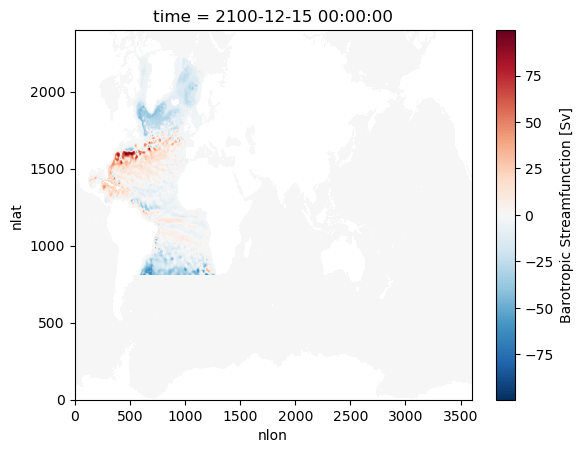

In [17]:
bsf.isel(time=-1).plot()

## Output to netcdf

In [18]:
%%time
# Save to netcdf
dsout = bsf.to_dataset()
fout = '/glade/scratch/tking/BSF/'+os.path.split(fin)[-1].replace('VVEL','BSF')
dsout.to_netcdf(fout,unlimited_dims='time')

CPU times: user 14min, sys: 24.7 s, total: 14min 25s
Wall time: 1h 11min 45s


In [19]:
bsf

,Array,Chunk
Bytes,73.39 GiB,4.12 MiB
Shape,"(1140, 2400, 3600)","(1, 150, 3600)"
Count,73126 Tasks,18240 Chunks
Type,float64,numpy.ndarray


# Compute BSF for Sunway Products

These need to be treated differently due to file format

In [11]:
fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/'
fin = fdir + 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.VVEL.*.nc'

vvel_files = sorted(glob.glob(fin))

In [12]:
dsV = xr.open_mfdataset(vvel_files, chunks={'time':1,'nlat':100}, parallel=True)

In [13]:
dsV.VVEL

<xarray.DataArray 'VVEL' (time: 1154, z_t: 62, nlat: 2400, nlon: 3600)>
dask.array<concatenate, shape=(1154, 62, 2400, 3600), dtype=float32, chunksize=(1, 62, 100, 3600), chunktype=numpy.ndarray>
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(100, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(100, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(100, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(100, 3600), meta=np.ndarray>
  * time     (time) object 2006-02-01 00:00:00 ... 2102-03-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Velocity in grid-y direction
    units:         centimeter/s
    grid_loc:      3221
    cell_methods:  time: mean

In [14]:
vvel = dsV['VVEL']
vvel = vvel.where(vvel<1.e30,0)/100.

### Region Mask & Grid Fields

In [17]:
## Define the MOC region mask:
rmask = ds_grid.REGION_MASK.drop(['ULONG','ULAT'])
rmaskatl = (rmask==6) | (rmask==8) | (rmask==9)

In [18]:
%%time
dz = ds_grid['dz'].persist()/100.
kmt = ds_grid['KMT'].fillna(0).persist() 
dxu = ds_grid['DXU'].persist()/100.
# the next step takes about 30 seconds when run in a notebook with 30GB allocated memory
# and about 12 minutes with the default 4GB allocated memory
dzt,dzu = popmoc.tx0p1v3_dztdzu(dz,kmt)

CPU times: user 11.3 s, sys: 9.43 s, total: 20.8 s
Wall time: 22.2 s


In [19]:
tlon = ds_grid.TLONG.drop(['ULONG','ULAT'])
tlat = ds_grid.TLAT.drop(['ULONG','ULAT'])
ulon = ds_grid.ULONG.drop(['TLONG','TLAT'])
ulat = ds_grid.ULAT.drop(['TLONG','TLAT'])

### Compute BSF

In [20]:
%%time
sv = (vvel*dzt*dxu).sum('z_t')
sv.attrs['units']='m^3/s'
sv_atl = sv.where(rmaskatl).drop(['TLONG','TLAT'])
bsf = sv_atl.cumsum('nlon')/1.e6
bsf = xr.where(rmaskatl,bsf,0)
bsf = bsf.assign_coords({'ULAT':ulat,'ULONG':ulon})
bsf = bsf.where(kmt!=0).drop(['TLONG','TLAT'])
bsf = bsf.assign_attrs({'units':'Sv','long_name':'Barotropic Streamfunction'}).rename('BSF')
bsf = bsf.transpose('time','nlat','nlon')

CPU times: user 15.2 s, sys: 1.74 s, total: 17 s
Wall time: 30.8 s


In [21]:
%%time
bsf = dask.optimize(bsf)[0]

CPU times: user 7.01 s, sys: 102 ms, total: 7.11 s
Wall time: 7.29 s


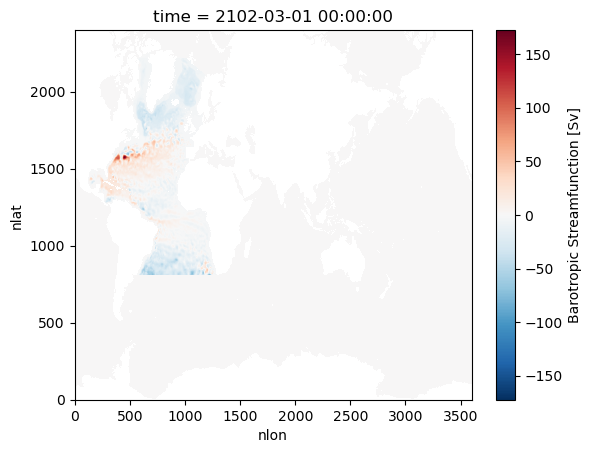

In [22]:
bsf.isel(time=-1).plot()

## Output to netcdf

In [23]:
%%time
# Save to netcdf
dsout = bsf.to_dataset()
fout = '/glade/scratch/tking/BSF/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.BSF.200601-210202.nc'
dsout.to_netcdf(fout,unlimited_dims='time')

CPU times: user 21min 50s, sys: 37.5 s, total: 22min 27s
Wall time: 1h 32min 42s


# Compute BSF for HR-DP Products

These need to be treated differently due to file format

In [9]:
list = [1,2,3,4,5]
list[2:]

[3, 4, 5]

In [ ]:
for member in range(2,11):
    if member < 10:
        member = '00'+str(member)
    else:
        member = '0'+str(member)
    print('working on member {}'.format(member))
    
    fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/HR-DP/*{}/ocn/proc/tseries/month_1/'.format(member)
    fin = fdir + 'b.e13.BDP-HR.ne120_t12.*.pop.h.VVEL.*.nc'
    print(fin)

    vvel_files = sorted(glob.glob(fin))
    
    # don't duplicate files that were already created on second iteration,
    # after first notebook failure. UPDATE THIS IF SCRIPT NEEDS TO RESTART!   
    if member=='002':
        vvel_files = vvel_files[16:]

    for vvelfile in vvel_files:
        print('vvelfile: {}'.format(vvelfile))
        print('creating {}'.format(vvelfile.split('/')[-1].replace('VVEL','BSF')))
        
        dsV = xr.open_mfdataset(vvelfile, chunks={'time':1,'nlat':100}, parallel=True)

        vvel = dsV['VVEL']
        vvel = vvel.where(vvel<1.e30,0)/100.
    
        # Region Mask & Grid Fields
        # Define the MOC region mask:
        rmask = ds_grid.REGION_MASK.drop(['ULONG','ULAT'])
        rmaskatl = (rmask==6) | (rmask==8) | (rmask==9)
    
        print('beginning dz/kmt/dxu step')
        dz = ds_grid['dz'].persist()/100.
        kmt = ds_grid['KMT'].fillna(0).persist() 
        dxu = ds_grid['DXU'].persist()/100.
        # the next step takes about 30 seconds when run in a notebook with 30GB allocated memory
        # and about 12 minutes with the default 4GB allocated memory
        dzt,dzu = popmoc.tx0p1v3_dztdzu(dz,kmt)
    
        tlon = ds_grid.TLONG.drop(['ULONG','ULAT'])
        tlat = ds_grid.TLAT.drop(['ULONG','ULAT'])
        ulon = ds_grid.ULONG.drop(['TLONG','TLAT'])
        ulat = ds_grid.ULAT.drop(['TLONG','TLAT'])
    
        # Compute BSF
        print('computing bsf')
        sv = (vvel*dzt*dxu).sum('z_t')
        sv.attrs['units']='m^3/s'
        sv_atl = sv.where(rmaskatl).drop(['TLONG','TLAT'])
        bsf = sv_atl.cumsum('nlon')/1.e6
        bsf = xr.where(rmaskatl,bsf,0)
        bsf = bsf.assign_coords({'ULAT':ulat,'ULONG':ulon})
        bsf = bsf.where(kmt!=0).drop(['TLONG','TLAT'])
        bsf = bsf.assign_attrs({'units':'Sv','long_name':'Barotropic Streamfunction'}).rename('BSF')
        bsf = bsf.transpose('time','nlat','nlon')
        bsf = dask.optimize(bsf)[0]
        # bsf.isel(time=-1).plot()
        dsout = bsf.to_dataset()
        fout = '/glade/scratch/tking/BSF/{}'.format(vvelfile.split('/')[-1].replace('VVEL','BSF'))
        dsout.to_netcdf(fout,unlimited_dims='time')
        print('created netcdf')

working on member 002
/glade/campaign/collections/cmip/CMIP6/iHESP/HR-DP/*002/ocn/proc/tseries/month_1/b.e13.BDP-HR.ne120_t12.*.pop.h.VVEL.*.nc
vvelfile: /glade/campaign/collections/cmip/CMIP6/iHESP/HR-DP/b.e13.BDP-HR.ne120_t12.2002-11.002/ocn/proc/tseries/month_1/b.e13.BDP-HR.ne120_t12.2002-11.002.pop.h.VVEL.200211-200712.nc
creating b.e13.BDP-HR.ne120_t12.2002-11.002.pop.h.BSF.200211-200712.nc
beginning dz/kmt/dxu step
computing bsf
created netcdf
vvelfile: /glade/campaign/collections/cmip/CMIP6/iHESP/HR-DP/b.e13.BDP-HR.ne120_t12.2004-11.002/ocn/proc/tseries/month_1/b.e13.BDP-HR.ne120_t12.2004-11.002.pop.h.VVEL.200411-200912.nc
creating b.e13.BDP-HR.ne120_t12.2004-11.002.pop.h.BSF.200411-200912.nc
beginning dz/kmt/dxu step
computing bsf
created netcdf
vvelfile: /glade/campaign/collections/cmip/CMIP6/iHESP/HR-DP/b.e13.BDP-HR.ne120_t12.2006-11.002/ocn/proc/tseries/month_1/b.e13.BDP-HR.ne120_t12.2006-11.002.pop.h.VVEL.200611-201112.nc
creating b.e13.BDP-HR.ne120_t12.2006-11.002.pop.h.BS

In [ ]:
cluster.scale(0)